In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import missingno as msno
import math

In [2]:
%%time
# dtype = {
#     'userID': 'int16',
#     'answerCode': 'int8',
#     'KnowledgeTag': 'int16',
# }   

# 데이터 경로 맞춰주세요!
# DATA_PATH = '/opt/ml/input/data/train_dataset/train_data.csv'
TRAIN_DATA_PATH = '/opt/ml/input/data/train_dataset/tuning_train_data.csv'
TEST_DATA_PATH = '/opt/ml/input/data/train_dataset/tuning_test_data.csv'
df_train = pd.read_csv(TRAIN_DATA_PATH, parse_dates=['Timestamp'])
df_test = pd.read_csv(TEST_DATA_PATH, parse_dates=['Timestamp'])

CPU times: user 8.66 s, sys: 1.25 s, total: 9.91 s
Wall time: 9.95 s


In [3]:
df_train['isTest'] = [0 for _ in range(len(df_train))]
df_test['isTest'] = [1 for _ in range(len(df_test))]
print(len(df_train), len(df_test))

2266586 260114


In [4]:
# train, test 합친 후 정렬
df = pd.concat([df_train,df_test])
df = df.sort_values(by=['isTest', 'userID', 'Timestamp']).reset_index(drop=True)

In [5]:
# df['Number'] = df['Number'].str.pad(width=6, side='left', fillchar='0')
# df['Number'] = df['Number'].transform(lambda x: 'A'+x)

# df['Category'] = df['assessmentItemID'].apply(lambda x: x[2])
# df['Number'] = df['assessmentItemID'].apply(lambda x: x[0]+x[-6:])

In [6]:
df['Time'] = df['Timestamp'].transform(lambda x: int(x.strftime('%s')))

In [7]:
# 가져올 열 선택
df = df[['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 
         'Category', 'Number', 'Time', 'solTime', 'item', 'item_order', 'test_size', 'retest', 'user_test_ans_cnt', 'isTest']]

In [8]:
df.dtypes

userID                        int64
assessmentItemID             object
testId                       object
answerCode                    int64
Timestamp            datetime64[ns]
KnowledgeTag                  int64
Category                      int64
Number                       object
Time                          int64
solTime                       int64
item                          int64
item_order                    int64
test_size                     int64
retest                        int64
user_test_ans_cnt             int64
isTest                        int64
dtype: object

In [9]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,Time,solTime,item,item_order,test_size,retest,user_test_ans_cnt,isTest
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,A001001,1585009031,3,0,0,6,0,0,0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,A001002,1585009034,8,1,1,6,0,1,0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,A001003,1585009042,7,2,2,6,0,2,0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6,A001004,1585009049,7,3,3,6,0,3,0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6,A001005,1585009056,11,4,4,6,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526695,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,4,A130001,1602716843,18,0,0,5,0,0,1
2526696,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,4,A130002,1602716861,21,1,1,5,0,1,1
2526697,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,4,A130003,1602716882,89,2,2,5,0,2,1
2526698,7439,A040130004,A040000130,1,2020-10-14 23:09:31,8244,4,A130004,1602716971,32,3,3,5,0,3,1


In [10]:
# 비율 계산하는 함수
def percentile(s):
    return np.sum(s) / len(s)

# Train & Test 데이터 확인

## User

In [11]:
df.groupby(['userID', 'isTest']).agg({'answerCode': 'mean'})

,,answerCode
userID,isTest,
0,0,0.630872
1,0,0.853162
2,0,0.612319
3,1,0.691120
4,1,0.691505
...,...,...
7437,0,0.375000
7438,0,0.750000
7439,1,0.625000


In [12]:
# train 데이터에 포함된 user들
user_train_groupby = df[df['isTest']==0].groupby('userID').agg({'answerCode': 'mean'})
user_train_groupby.index

Int64Index([   0,    1,    2,    5,    6,    7,    8,    9,   10,   11,
            ...
            7431, 7432, 7433, 7434, 7435, 7436, 7437, 7438, 7440, 7441],
           dtype='int64', name='userID', length=6698)

In [13]:
# test 데이터에 포함된 user들
user_test_groupby = df[df['isTest']==1].groupby('userID').agg({'answerCode': 'mean'})
user_test_groupby.index

Int64Index([   3,    4,   13,   17,   26,   29,   45,   53,   58,   64,
            ...
            7368, 7369, 7373, 7382, 7392, 7395, 7404, 7416, 7417, 7439],
           dtype='int64', name='userID', length=744)

In [14]:
# 겹치는 user 수 확인
s1 = set(user_train_groupby.index)
s2 = set(user_test_groupby.index)
print(len(s1), len(s2), len(s1 & s2))

6698 744 0


## 문제

In [15]:
df.groupby(['assessmentItemID', 'isTest']).agg({'answerCode': 'mean'})

answerCode
assessmentItemID isTest            
A010001001       0         0.930599
                 1         0.848485
A010001002       0         0.958991
                 1         0.969697
A010001003       0         0.905363
...                             ...
A090074004       1         0.600000
A090074005       0         0.400000
                 1         0.400000
A090074006       0         0.466667
                 1        -0.600000

[18908 rows x 1 columns]

In [16]:
# train 데이터에 포함된 문제들
prob_train_groupby = df[df['isTest']==0].groupby('assessmentItemID').agg({'answerCode': 'mean'})
prob_train_groupby.index

Index(['A010001001', 'A010001002', 'A010001003', 'A010001004', 'A010001005',
       'A010002001', 'A010002002', 'A010002003', 'A010002004', 'A010002005',
       ...
       'A090073003', 'A090073004', 'A090073005', 'A090073006', 'A090074001',
       'A090074002', 'A090074003', 'A090074004', 'A090074005', 'A090074006'],
      dtype='object', name='assessmentItemID', length=9454)

In [17]:
# test 데이터에 포함된 문제들
prob_test_groupby = df[df['isTest']==1].groupby('assessmentItemID').agg({'answerCode': 'mean'})
prob_test_groupby.index

Index(['A010001001', 'A010001002', 'A010001003', 'A010001004', 'A010001005',
       'A010002001', 'A010002002', 'A010002003', 'A010002004', 'A010002005',
       ...
       'A090073003', 'A090073004', 'A090073005', 'A090073006', 'A090074001',
       'A090074002', 'A090074003', 'A090074004', 'A090074005', 'A090074006'],
      dtype='object', name='assessmentItemID', length=9454)

In [18]:
# 겹치는 문제 수 확인
s1 = set(prob_train_groupby.index)
s2 = set(prob_test_groupby.index)
print(len(s1), len(s2), len(s1 & s2))

9454 9454 9454


In [19]:
# 예측할 데이터에 포함된 문제들
pred_prob_list = df[df['answerCode']==-1].groupby('assessmentItemID').agg({'answerCode': 'sum'}).index.tolist()
len(pred_prob_list)

444

# Timestamp

In [20]:
df1 = df.copy()

## solTime 20분 넘으면 자르기

In [21]:
df1_1 = df1.copy()
df1_1['soltTime_cate'] = np.digitize(df1['solTime'], bins=[1200])
solTime_groupby = df1_1.groupby('soltTime_cate').agg({'userID': 'count'})
solTime_groupby.index.name = 'solTime_cate'
solTime_groupby.reset_index(inplace=True)
solTime_groupby

,solTime_cate,userID
0,0,2510222
1,1,16478


<AxesSubplot:ylabel='userID'>

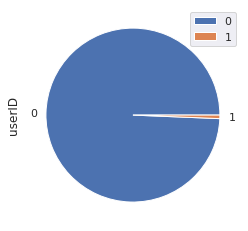

In [22]:
solTime_groupby.plot.pie(x='solTime_cate', y='userID')

In [23]:
len(df1[df1['solTime'] <= 1200])

2510239

In [24]:
len(df1[df1['solTime'] > 1200])

16461

In [25]:
df1['clipped_solTime'] = df1['solTime'].transform(lambda x: x if x <= 1200 else 1200)
df1['clipped_solTime'].describe()

count    2.526700e+06
mean     5.840498e+01
std      1.378449e+02
min      0.000000e+00
25%      3.000000e+00
50%      2.000000e+01
75%      5.300000e+01
max      1.200000e+03
Name: clipped_solTime, dtype: float64

In [26]:
clipped_solTime_groupby = df1.groupby('clipped_solTime').agg({'answerCode': 'mean'})
clipped_solTime_groupby.index.name = 'clipped_solTime'
clipped_solTime_groupby.reset_index(inplace=True)
clipped_solTime_groupby

,clipped_solTime,answerCode
0,0,0.555302
1,1,0.258033
2,2,0.240093
3,3,0.258814
4,4,0.288840
...,...,...
1196,1196,0.666667
1197,1197,0.800000
1198,1198,0.642857
1199,1199,0.789474


In [27]:
clipped_solTime_groupby.head(20)

,clipped_solTime,answerCode
0,0,0.555302
1,1,0.258033
2,2,0.240093
3,3,0.258814
4,4,0.288840
5,5,0.369946
6,6,0.480051
7,7,0.580775
8,8,0.641993
9,9,0.688726


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='clipped_solTime', ylabel='answerCode'>

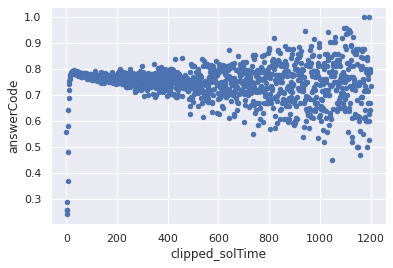

In [28]:
clipped_solTime_groupby.plot.scatter(x='clipped_solTime', y='answerCode')

In [29]:
# 카테고리화
df1['clipped_solTime_cate'] = df1['clipped_solTime'].transform(lambda x: math.floor(x/10))
df1[['clipped_solTime','clipped_solTime_cate']]

,clipped_solTime,clipped_solTime_cate
0,3,0
1,8,0
2,7,0
3,7,0
4,11,1
...,...,...
2526695,18,1
2526696,21,2
2526697,89,8
2526698,32,3


In [30]:
clipped_solTime_cate_groupby = df1.groupby('clipped_solTime_cate').agg({'answerCode': 'mean'})
clipped_solTime_cate_groupby.index.name = 'clipped_solTime_cate'
clipped_solTime_cate_groupby.reset_index(inplace=True)
clipped_solTime_cate_groupby

,clipped_solTime_cate,answerCode
0,0,0.449027
1,1,0.762898
2,2,0.785629
3,3,0.784828
4,4,0.781732
...,...,...
116,116,0.783626
117,117,0.721088
118,118,0.711268
119,119,0.697842


## 문제 풀이에 사용한 총 시간 

In [31]:
df1['total_used_time'] = df1.groupby(['userID', 'testId'])['solTime'].cumsum()

## 최근 3문제 평균 풀이 시간

In [32]:
df1['moving_average_time'] = df1.groupby(['userID'])['clipped_solTime'].rolling(3).mean().fillna(0).values
df1[['userID', 'solTime', 'moving_average_time']]

,userID,solTime,moving_average_time
0,0,3,0.000000
1,0,8,0.000000
2,0,7,6.000000
3,0,7,7.333333
4,0,11,8.333333
...,...,...,...
2526695,7439,18,19.333333
2526696,7439,21,11.666667
2526697,7439,89,19.000000
2526698,7439,32,43.333333


In [33]:
moving_average_time_groupby = df1.groupby('moving_average_time').agg({'answerCode': 'mean'})
moving_average_time_groupby.index.name = 'moving_average_time'
moving_average_time_groupby.reset_index(inplace=True)
moving_average_time_groupby

,moving_average_time,answerCode
0,0.000000,0.640629
1,0.333333,0.644273
2,0.666667,0.650462
3,1.000000,0.645355
4,1.333333,0.645904
...,...,...
3129,1196.000000,1.000000
3130,1196.333333,1.000000
3131,1197.333333,1.000000
3132,1198.666667,1.000000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='moving_average_time', ylabel='answerCode'>

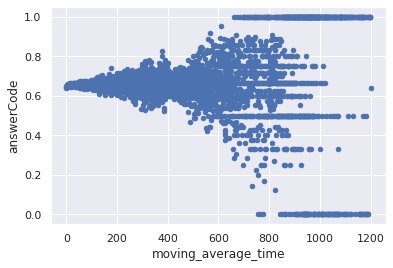

In [34]:
moving_average_time_groupby.plot.scatter(x='moving_average_time', y='answerCode')

## 시간대 & 요일

In [35]:
df1['hour'] = df1['Timestamp'].transform(lambda x: pd.to_datetime(x).dt.hour)
df1['weekday'] = df1['Timestamp'].transform(lambda x: pd.to_datetime(x).dt.weekday)

In [36]:
hour_groupby = df1.groupby('hour').agg({'answerCode': 'mean'})
hour_groupby.index.name = 'hour'
hour_groupby.reset_index(inplace=True)
hour_groupby

,hour,answerCode
0,0,0.650462
1,1,0.644876
2,2,0.642090
3,3,0.633329
4,4,0.633352
5,5,0.624684
6,6,0.628330
7,7,0.641452
8,8,0.669495
9,9,0.682831


<AxesSubplot:xlabel='hour'>

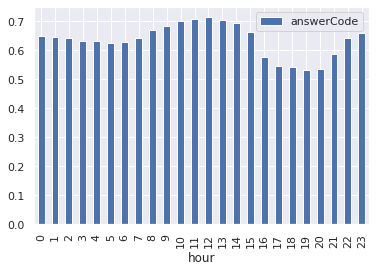

In [37]:
hour_groupby.plot.bar(x='hour', y='answerCode')

In [38]:
weekday_groupby = df1.groupby('weekday').agg({'answerCode': 'mean'})
weekday_groupby.index.name = 'weekday'
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
weekday_groupby['weekday_name'] = days
weekday_groupby.reset_index(inplace=True)
weekday_groupby.head(24)

,weekday,answerCode,weekday_name
0,0,0.675781,Mon
1,1,0.667045,Tue
2,2,0.641120,Wed
3,3,0.657922,Thu
4,4,0.643650,Fri
5,5,0.603369,Sat
6,6,0.674146,Sun


<AxesSubplot:xlabel='weekday_name'>

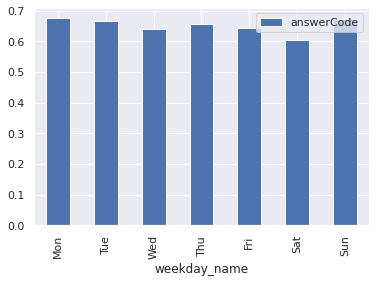

In [39]:
weekday_groupby.plot.bar(x='weekday_name', y='answerCode')

In [40]:
df1

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,Time,solTime,...,test_size,retest,user_test_ans_cnt,isTest,clipped_solTime,clipped_solTime_cate,total_used_time,moving_average_time,hour,weekday
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,A001001,1585009031,3,...,6,0,0,0,3,0,3,0.000000,0,1
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,A001002,1585009034,8,...,6,0,1,0,8,0,11,0.000000,0,1
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,A001003,1585009042,7,...,6,0,2,0,7,0,18,6.000000,0,1
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6,A001004,1585009049,7,...,6,0,3,0,7,0,25,7.333333,0,1
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6,A001005,1585009056,11,...,6,0,4,0,11,1,36,8.333333,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526695,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,4,A130001,1602716843,18,...,5,0,0,1,18,1,18,19.333333,23,2
2526696,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,4,A130002,1602716861,21,...,5,0,1,1,21,2,39,11.666667,23,2
2526697,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,4,A130003,1602716882,89,...,5,0,2,1,89,8,128,19.000000,23,2
2526698,7439,A040130004,A040000130,1,2020-10-14 23:09:31,8244,4,A130004,1602716971,32,...,5,0,3,1,32,3,160,43.333333,23,2


# 횟수 & 정답률 

In [41]:
df2 = df1.copy()

In [42]:
# 시간 순서대로 정렬
df2 = df2.sort_values(by=['Timestamp', 'isTest']).reset_index(drop=True)

In [43]:
df2

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,Time,solTime,...,test_size,retest,user_test_ans_cnt,isTest,clipped_solTime,clipped_solTime_cate,total_used_time,moving_average_time,hour,weekday
0,784,A060014001,A060000014,1,2019-12-31 15:08:01,7229,6,A014001,1577804881,20,...,5,0,0,0,20,2,20,16.000000,15,1
1,784,A060014002,A060000014,1,2019-12-31 15:08:21,7229,6,A014002,1577804901,34,...,5,0,1,0,34,3,54,14.333333,15,1
2,784,A060014003,A060000014,1,2019-12-31 15:08:55,7229,6,A014003,1577804935,18,...,5,0,2,0,18,1,72,19.000000,15,1
3,784,A060014004,A060000014,1,2019-12-31 15:09:13,7229,6,A014004,1577804953,16,...,5,0,3,0,16,1,88,26.666667,15,1
4,784,A060014005,A060000014,0,2019-12-31 15:09:29,7229,6,A014005,1577804969,0,...,5,0,4,0,0,0,88,37.000000,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526695,588,A070152004,A070000152,0,2020-12-29 16:46:08,7866,7,A152004,1609260368,5,...,8,0,3,0,5,0,54,16.000000,16,1
2526696,588,A070152005,A070000152,1,2020-12-29 16:46:13,3288,7,A152005,1609260373,2,...,8,0,4,0,2,0,56,18.333333,16,1
2526697,588,A070152006,A070000152,0,2020-12-29 16:46:15,9078,7,A152006,1609260375,3,...,8,0,5,0,3,0,59,6.333333,16,1
2526698,588,A070152007,A070000152,0,2020-12-29 16:46:18,9080,7,A152007,1609260378,3,...,8,0,6,0,3,0,62,13.000000,16,1


In [44]:
df2_1 = df2[df2['answerCode'] != -1]
len(df2_1)

2525956

## 문항별

In [45]:
df_prob = df2.groupby('assessmentItemID')['answerCode']

# 특정 문항 과거에 푼 횟수
df2['past_prob_count'] = df_prob.cumcount()

# 특정 문항 과거에 맞춘 횟수
df2['shift'] = df_prob.shift().fillna(0)
df2['past_prob_correct'] = df2.groupby('assessmentItemID')['shift'].cumsum()
df2 = df2.drop(columns='shift')

# 특정 문항 과거 평균 정답률
df2['average_prob_correct'] = (df2['past_prob_correct'] / df2['past_prob_count']).fillna(0)

In [46]:
prob_groupby = df2.groupby('past_prob_count').agg({
    'answerCode': percentile
})
prob_groupby.index.name = 'past_prob_count'
prob_groupby.reset_index(inplace=True)
prob_groupby.describe()

,past_prob_count,answerCode
count,500.000000,500.000000
mean,249.500000,0.583850
std,144.481833,0.118000
min,0.000000,0.125000
25%,124.750000,0.499259
50%,249.500000,0.641802
75%,374.250000,0.662472
max,499.000000,0.757351


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='past_prob_count', ylabel='answerCode'>

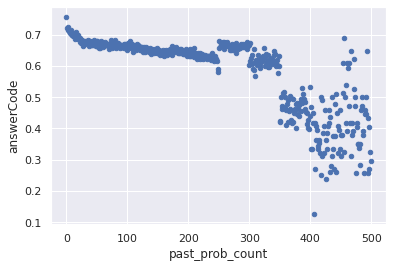

In [47]:
prob_groupby.plot.scatter(x='past_prob_count', y='answerCode')

## 문항별(전체)

In [48]:
# 문항별 전체 정답률
prob_groupby = df2_1.groupby(['assessmentItemID'])['answerCode'].agg(['mean', 'sum'])
prob_groupby.columns = ['prob_mean', 'prob_sum']

In [49]:
df2 = pd.merge(df2, prob_groupby, on=['assessmentItemID'], how="left")

In [50]:
# 카테고리화
df2['prob_mean_cate'] = df2['prob_mean'].transform(lambda x: math.floor(x*10))
df2[['prob_mean','prob_mean_cate']]

,prob_mean,prob_mean_cate
0,0.892,8
1,0.892,8
2,0.340,3
3,0.588,5
4,0.232,2
...,...,...
2526695,0.670,6
2526696,0.600,6
2526697,0.330,3
2526698,0.490,4


In [51]:
df2[df2['average_prob_correct']==float("inf")]['past_prob_correct']

Series([], Name: past_prob_correct, dtype: float64)

## 시험지별

In [52]:
df_test = df2.groupby('testId')['answerCode']

# 특정 시험지 과거에 푼 횟수
df2['past_test_count'] = df_test.cumcount()

# 특정 시험지 과거에 맞춘 횟수
df2['shift'] = df_test.shift().fillna(0)
df2['past_test_correct'] = df2.groupby('testId')['shift'].cumsum()
df2 = df2.drop(columns='shift')

# 특정 시험지 과거 평균 정답률
df2['average_test_correct'] = (df2['past_test_correct'] / df2['past_test_count']).fillna(0)

In [53]:
test_groupby = df2.groupby('past_test_count').agg({
    'answerCode': percentile
})
test_groupby.index.name = 'past_test_count'
test_groupby.reset_index(inplace=True)
test_groupby.describe()

,past_test_count,answerCode
count,4400.000000,4400.000000
mean,2199.500000,0.552078
std,1270.314922,0.196285
min,0.000000,-1.000000
25%,1099.750000,0.462753
50%,2199.500000,0.575702
75%,3299.250000,0.671242
max,4399.000000,1.000000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='past_test_count', ylabel='answerCode'>

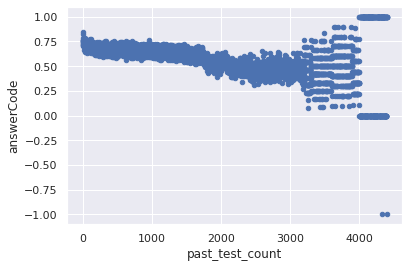

In [54]:
test_groupby.plot.scatter(x='past_test_count', y='answerCode')

## 시험지별(전체)

In [55]:
# 시험지별 전체 정답률
test_groupby = df2_1.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
test_groupby.columns = ["test_mean", 'test_sum']

In [56]:
df2 = pd.merge(df2, test_groupby, on=['testId'], how="left")

## 태그별

In [57]:
df_tag = df2.groupby('KnowledgeTag')['answerCode']

# 특정 태그 과거에 푼 횟수
df2['past_tag_count'] = df_tag.cumcount()

# 특정 태그 과거에 맞춘 횟수
df2['shift'] = df_tag.shift().fillna(0)
df2['past_tag_correct'] = df2.groupby('KnowledgeTag')['shift'].cumsum()
df2 = df2.drop(columns='shift')

# 특정 태그 과거 평균 정답률
df2['average_tag_correct'] = (df2['past_tag_correct'] / df2['past_tag_count']).fillna(0)

In [58]:
tag_groupby = df2.groupby('past_tag_count').agg({
    'answerCode': percentile
})
tag_groupby.index.name = 'past_tag_count'
tag_groupby.reset_index(inplace=True)
tag_groupby.describe()

,past_tag_count,answerCode
count,14350.000000,14350.000000
mean,7174.500000,0.697500
std,4142.632516,0.211853
min,0.000000,0.000000
25%,3587.250000,0.625000
50%,7174.500000,0.666667
75%,10761.750000,0.783235
max,14349.000000,1.000000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='past_tag_count', ylabel='answerCode'>

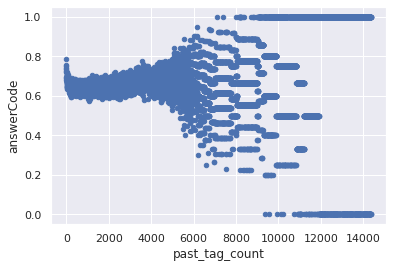

In [59]:
tag_groupby.plot.scatter(x='past_tag_count', y='answerCode')

## 태그별(전체)

In [60]:
# 태그별 전체 정답률
tag_groupby = df2_1.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
tag_groupby.columns = ["tag_mean", 'tag_sum']

In [61]:
df2 = pd.merge(df2, tag_groupby, on=['KnowledgeTag'], how="left")

## 사용자별

In [62]:
df_user = df2.groupby('userID')['answerCode']

# 과거에 푼 문제 수
df2['past_user_count'] = df_user.cumcount()

# 과거에 맞춘 문제 수
df2['shift'] = df_user.shift().fillna(0)
df2['past_user_correct'] = df2.groupby('userID')['shift'].cumsum()
df2 = df2.drop(columns='shift')

# 과거 평균 정답률
df2['average_user_correct'] = (df2['past_user_correct'] / df2['past_user_count']).fillna(0)

In [63]:
user_groupby = df2.groupby('past_user_count').agg({
    'answerCode': percentile
})
user_groupby.index.name = 'past_user_count'
user_groupby.reset_index(inplace=True)
user_groupby.describe()

,past_user_count,answerCode
count,1860.000000,1860.000000
mean,929.500000,0.647544
std,537.080069,0.105707
min,0.000000,0.000000
25%,464.750000,0.642489
50%,929.500000,0.657800
75%,1394.250000,0.673501
max,1859.000000,1.000000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='past_user_count', ylabel='answerCode'>

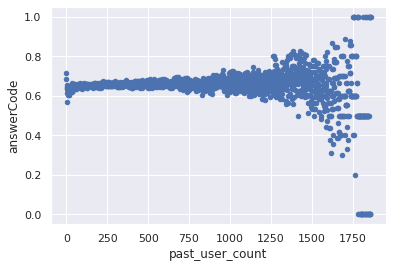

In [64]:
user_groupby.plot.scatter(x='past_user_count', y='answerCode')

In [65]:
# 카테고리화
df2['average_user_correct_cate'] = df2['average_user_correct'].transform(lambda x: math.floor(x*10))
df2[['average_user_correct','average_user_correct_cate']]

,average_user_correct,average_user_correct_cate
0,0.000000,0
1,1.000000,10
2,1.000000,10
3,1.000000,10
4,1.000000,10
...,...,...
2526695,0.538462,5
2526696,0.537600,5
2526697,0.538339,5
2526698,0.537480,5


In [66]:
# 이동평균(추세)
df2['shift'] = df2.groupby('userID')['answerCode'].shift().fillna(0)
df2['moving_average_user_correct'] = df2['shift'].rolling(10).mean().fillna(0)
df2 = df2.drop(columns='shift')
df2[df2['userID']==0][['answerCode', 'moving_average_user_correct']].head(30)

,answerCode,moving_average_user_correct
267671,1,0.6
267672,1,0.6
267675,1,0.9
267678,1,0.9
267681,1,1.0
267685,1,1.0
289272,0,0.6
289274,1,0.5
289294,1,0.7
289300,1,0.7


In [67]:
moving_user_groupby = df2.groupby('moving_average_user_correct').agg({
    'answerCode': percentile
})
moving_user_groupby.index.name = 'moving_average_user_correct'
moving_user_groupby.reset_index(inplace=True)
moving_user_groupby.describe()

,moving_average_user_correct,answerCode
count,11.000000,11.000000
mean,0.500000,0.559748
std,0.331662,0.187378
min,0.000000,0.258710
25%,0.250000,0.421582
50%,0.500000,0.571950
75%,0.750000,0.715218
max,1.000000,0.807682


In [68]:
moving_user_groupby

,moving_average_user_correct,answerCode
0,0.0,0.258710
1,0.1,0.324924
2,0.2,0.390284
3,0.3,0.452880
4,0.4,0.511315
5,0.5,0.571950
6,0.6,0.634447
7,0.7,0.691216
8,0.8,0.739220
9,0.9,0.774598


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='moving_average_user_correct', ylabel='answerCode'>

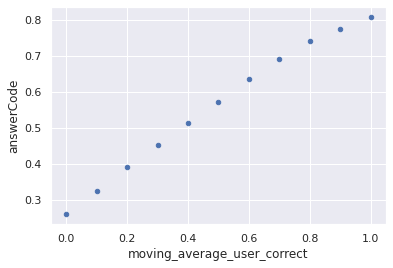

In [69]:
moving_user_groupby.plot.scatter(x='moving_average_user_correct', y='answerCode')

## 사용자 + 문항별

In [70]:
df_user_prob = df2.groupby(['userID','assessmentItemID'])['answerCode']

# 과거에 해당 문제를 푼 수
df2['past_user_prob_count'] = df_user_prob.cumcount()

# 과거에 해당 문제를 맞춘 횟수
df2['shift'] = df_user_prob.shift().fillna(0)
df2['past_user_prob_correct'] = df2.groupby(['userID', 'assessmentItemID'])['shift'].cumsum()
df2 = df2.drop(columns='shift')

# 과거 해당 문제 평균 정답률
df2['average_user_prob_correct'] = (df2['past_user_prob_correct'] / df2['past_user_prob_count']).fillna(0)

In [71]:
user_prob_groupby = df2.groupby('past_user_prob_count').agg({
    'userID': 'count',
    'answerCode': percentile
})
user_prob_groupby.index.name = 'past_user_prob_count'
user_prob_groupby.reset_index(inplace=True)
user_prob_groupby

,past_user_prob_count,userID,answerCode
0,0,2476706,0.654363
1,1,49100,0.647088
2,2,894,0.454139


<AxesSubplot:ylabel='userID'>

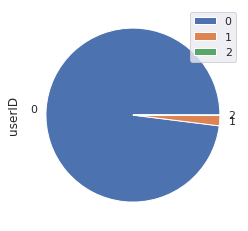

In [72]:
user_prob_groupby.plot.pie(x='past_user_prob_count', y='userID')

## 사용자 + 시험지별

In [73]:
df_user_test = df2.groupby(['userID','testId'])['answerCode']

# 과거에 해당 시험지를 푼 수
df2['past_user_test_count'] = df_user_test.cumcount()

# 과거에 해당 시험지를 맞춘 횟수
df2['shift'] = df_user_test.shift().fillna(0)
df2['past_user_test_correct'] = df2.groupby(['userID', 'testId'])['shift'].cumsum()
df2 = df2.drop(columns='shift')

# 과거 해당 시험지 평균 정답률
df2['average_user_test_correct'] = (df2['past_user_test_correct'] / df2['past_user_test_count']).fillna(0)

In [74]:
user_test_groupby = df2.groupby('past_user_test_count').agg({
    'userID': 'count',
    'answerCode': percentile
})
user_test_groupby.index.name = 'past_user_test_count'
user_test_groupby.reset_index(inplace=True)
user_test_groupby

,past_user_test_count,userID,answerCode
0,0,407189,0.750863
1,1,407189,0.721446
2,2,406901,0.690455
3,3,405125,0.662892
4,4,391445,0.598122
5,5,219828,0.557677
6,6,142792,0.518208
7,7,79233,0.468353
8,8,27039,0.528163
9,9,13399,0.580416


## 사용자 + 태그별

In [75]:
df_user_tag = df2.groupby(['userID','KnowledgeTag'])['answerCode']

# 과거에 해당 태그를 푼 수
df2['past_user_tag_count'] = df_user_tag.cumcount()

# 과거에 해당 태그를 맞춘 횟수
df2['shift'] = df_user_tag.shift().fillna(0)
df2['past_user_tag_correct'] = df2.groupby(['userID', 'KnowledgeTag'])['shift'].cumsum()
df2 = df2.drop(columns='shift')

# 과거 해당 태그 평균 정답률
df2['average_user_tag_correct'] = (df2['past_user_tag_correct'] / df2['past_user_tag_count']).fillna(0)

In [76]:
user_tag_groupby = df2.groupby('past_user_tag_count').agg({
    'userID': 'count',
    'answerCode': percentile
})
user_tag_groupby.index.name = 'past_user_tag_count'
user_tag_groupby.reset_index(inplace=True)
user_tag_groupby

,past_user_tag_count,userID,answerCode
0,0,492354,0.687444
1,1,422906,0.669106
2,2,367129,0.650831
3,3,315447,0.643243
4,4,269447,0.599376
...,...,...,...
103,103,1,1.000000
104,104,1,1.000000
105,105,1,0.000000
106,106,1,0.000000


# CSV 파일 저장

In [77]:
df2.dtypes

userID                                  int64
assessmentItemID                       object
testId                                 object
answerCode                              int64
Timestamp                      datetime64[ns]
KnowledgeTag                            int64
Category                                int64
Number                                 object
Time                                    int64
solTime                                 int64
item                                    int64
item_order                              int64
test_size                               int64
retest                                  int64
user_test_ans_cnt                       int64
isTest                                  int64
clipped_solTime                         int64
clipped_solTime_cate                    int64
total_used_time                         int64
moving_average_time                   float64
hour                                    int64
weekday                           

In [78]:
df2

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,Time,solTime,...,moving_average_user_correct,past_user_prob_count,past_user_prob_correct,average_user_prob_correct,past_user_test_count,past_user_test_correct,average_user_test_correct,past_user_tag_count,past_user_tag_correct,average_user_tag_correct
0,784,A060014001,A060000014,1,2019-12-31 15:08:01,7229,6,A014001,1577804881,20,...,0.0,0,0.0,0.0,0,0.0,0.000000,0,0.0,0.00
1,784,A060014002,A060000014,1,2019-12-31 15:08:21,7229,6,A014002,1577804901,34,...,0.0,0,0.0,0.0,1,1.0,1.000000,1,1.0,1.00
2,784,A060014003,A060000014,1,2019-12-31 15:08:55,7229,6,A014003,1577804935,18,...,0.0,0,0.0,0.0,2,2.0,1.000000,2,2.0,1.00
3,784,A060014004,A060000014,1,2019-12-31 15:09:13,7229,6,A014004,1577804953,16,...,0.0,0,0.0,0.0,3,3.0,1.000000,3,3.0,1.00
4,784,A060014005,A060000014,0,2019-12-31 15:09:29,7229,6,A014005,1577804969,0,...,0.0,0,0.0,0.0,4,4.0,1.000000,4,4.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526695,588,A070152004,A070000152,0,2020-12-29 16:46:08,7866,7,A152004,1609260368,5,...,0.1,0,0.0,0.0,3,1.0,0.333333,0,0.0,0.00
2526696,588,A070152005,A070000152,1,2020-12-29 16:46:13,3288,7,A152005,1609260373,2,...,0.1,0,0.0,0.0,4,1.0,0.250000,1,0.0,0.00
2526697,588,A070152006,A070000152,0,2020-12-29 16:46:15,9078,7,A152006,1609260375,3,...,0.2,0,0.0,0.0,5,2.0,0.400000,5,4.0,0.80
2526698,588,A070152007,A070000152,0,2020-12-29 16:46:18,9080,7,A152007,1609260378,3,...,0.2,0,0.0,0.0,6,2.0,0.333333,8,6.0,0.75


In [79]:
df2 = df2.sort_values(by=['isTest', 'userID', 'Timestamp']).reset_index(drop=True)

In [80]:
df_new = df2
df_train_new = df_new[df_new['isTest'] == 0]
df_test_new = df_new[df_new['isTest'] == 1]

In [81]:
df_train_new

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,Time,solTime,...,moving_average_user_correct,past_user_prob_count,past_user_prob_correct,average_user_prob_correct,past_user_test_count,past_user_test_correct,average_user_test_correct,past_user_tag_count,past_user_tag_correct,average_user_tag_correct
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,A001001,1585009031,3,...,0.6,0,0.0,0.0,0,0.0,0.00,0,0.0,0.00
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,A001002,1585009034,8,...,0.6,0,0.0,0.0,1,1.0,1.00,0,0.0,0.00
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,A001003,1585009042,7,...,0.9,0,0.0,0.0,2,2.0,1.00,1,1.0,1.00
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6,A001004,1585009049,7,...,0.9,0,0.0,0.0,3,3.0,1.00,2,2.0,1.00
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6,A001005,1585009056,11,...,1.0,0,0.0,0.0,4,4.0,1.00,3,3.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,3,A071005,1591339821,0,...,0.7,0,0.0,0.0,4,1.0,0.25,4,1.0,0.25
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,4,A165001,1597971999,11,...,0.5,0,0.0,0.0,0,0.0,0.00,0,0.0,0.00
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,4,A165002,1597972010,46,...,0.5,0,0.0,0.0,1,1.0,1.00,1,1.0,1.00
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,4,A165003,1597972056,73,...,0.6,0,0.0,0.0,2,2.0,1.00,2,2.0,1.00


In [82]:
df_test_new

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,Time,solTime,...,moving_average_user_correct,past_user_prob_count,past_user_prob_correct,average_user_prob_correct,past_user_test_count,past_user_test_correct,average_user_test_correct,past_user_tag_count,past_user_tag_correct,average_user_tag_correct
2266586,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,5,A023001,1578567391,26,...,0.4,0,0.0,0.0,0,0.0,0.000000,0,0.0,0.0
2266587,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,5,A023002,1578567417,94,...,0.5,0,0.0,0.0,1,1.0,1.000000,1,1.0,1.0
2266588,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625,5,A023003,1578567511,5,...,0.5,0,0.0,0.0,2,2.0,1.000000,0,0.0,0.0
2266589,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625,5,A023004,1578567516,7,...,0.5,0,0.0,0.0,3,2.0,0.666667,1,0.0,0.0
2266590,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623,5,A023006,1578567523,3,...,0.5,0,0.0,0.0,4,2.0,0.500000,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526695,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,4,A130001,1602716843,18,...,0.6,0,0.0,0.0,0,0.0,0.000000,0,0.0,0.0
2526696,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,4,A130002,1602716861,21,...,0.6,0,0.0,0.0,1,0.0,0.000000,1,0.0,0.0
2526697,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,4,A130003,1602716882,89,...,0.7,0,0.0,0.0,2,1.0,0.500000,0,0.0,0.0
2526698,7439,A040130004,A040000130,1,2020-10-14 23:09:31,8244,4,A130004,1602716971,32,...,0.7,0,0.0,0.0,3,2.0,0.666667,1,1.0,1.0


In [83]:
# df_train_new.to_csv("/opt/ml/input/data/train_dataset/tuning_train_data_bm.csv", mode='w')
# df_test_new.to_csv("/opt/ml/input/data/train_dataset/tuning_test_data_bm.csv", mode='w')

# Feature Selection

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm;
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
%matplotlib inline

In [85]:
df_new = pd.read_csv('/opt/ml/input/data/train_dataset/tuning_train_data_bm.csv', index_col = 0)
df_new.head()

/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,Time,solTime,...,moving_average_user_correct,past_user_prob_count,past_user_prob_correct,average_user_prob_correct,past_user_test_count,past_user_test_correct,average_user_test_correct,past_user_tag_count,past_user_tag_correct,average_user_tag_correct
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,A001001,1585009031,3,...,0.6,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,A001002,1585009034,8,...,0.6,0,0.0,0.0,1,1.0,1.0,0,0.0,0.0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,A001003,1585009042,7,...,0.9,0,0.0,0.0,2,2.0,1.0,1,1.0,1.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6,A001004,1585009049,7,...,0.9,0,0.0,0.0,3,3.0,1.0,2,2.0,1.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6,A001005,1585009056,11,...,1.0,0,0.0,0.0,4,4.0,1.0,3,3.0,1.0


## Correlation

In [86]:
corr = df_new.corr()
corr.style.background_gradient(cmap='coolwarm')

/opt/conda/lib/python3.7/site-packages/pandas/io/formats/style.py:1264: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/opt/conda/lib/python3.7/site-packages/pandas/io/formats/style.py:1265: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


,userID,answerCode,KnowledgeTag,Category,Time,solTime,item,item_order,test_size,retest,user_test_ans_cnt,isTest,clipped_solTime,clipped_solTime_cate,total_used_time,moving_average_time,hour,weekday,past_prob_count,past_prob_correct,average_prob_correct,prob_mean,prob_sum,prob_mean_cate,past_test_count,past_test_correct,average_test_correct,test_mean,test_sum,past_tag_count,past_tag_correct,average_tag_correct,tag_mean,tag_sum,past_user_count,past_user_correct,average_user_correct,average_user_correct_cate,moving_average_user_correct,past_user_prob_count,past_user_prob_correct,average_user_prob_correct,past_user_test_count,past_user_test_correct,average_user_test_correct,past_user_tag_count,past_user_tag_correct,average_user_tag_correct
userID,1.000000,-0.035235,-0.015064,-0.065891,0.126468,0.001403,-0.021852,-0.022368,-0.059114,-0.055051,-0.022368,nan,-0.003472,-0.003504,0.003705,-0.004785,0.004288,-0.006477,0.080045,0.096495,0.039283,0.052678,0.032533,0.051999,0.048242,0.079263,0.052806,0.072016,0.002406,0.061919,0.069386,0.052719,0.068817,0.002227,-0.457448,-0.440139,-0.130881,-0.120485,-0.010860,-0.055051,-0.044331,-0.043616,-0.044494,-0.058561,-0.034785,-0.146839,-0.143149,-0.054388
answerCode,-0.035235,1.000000,0.012086,-0.201841,-0.036482,0.001408,-0.165713,-0.166232,-0.133862,-0.004983,-0.168630,nan,0.089418,0.087016,-0.001777,0.001951,0.005886,-0.021898,-0.052228,0.127613,0.379365,0.413354,0.332356,0.409026,-0.100696,0.002337,0.296278,0.302507,0.105170,0.021573,0.082372,0.285782,0.288721,0.162191,0.012336,0.079323,0.290078,0.287031,0.228730,-0.004976,0.009079,0.009796,-0.154971,0.114325,0.258937,-0.017581,0.131991,0.252647
KnowledgeTag,-0.015064,0.012086,1.000000,-0.150631,0.130494,0.000333,0.012776,0.012306,-0.009111,-0.003072,0.011801,nan,-0.016279,-0.015920,-0.000059,-0.001498,-0.009568,-0.000431,0.019954,0.036517,0.022421,0.030037,0.080926,0.029797,0.009914,0.020877,0.040849,0.051153,0.057413,0.002524,0.032146,0.036652,0.042304,0.055972,0.091193,0.080306,0.010607,0.008702,-0.024281,-0.003070,-0.001608,-0.001214,0.008952,0.002144,0.010762,-0.001329,0.014204,-0.000128
Category,-0.065891,-0.201841,-0.150631,1.000000,0.043472,0.006320,0.236791,0.238361,0.629931,0.012922,0.238361,nan,-0.005284,-0.004210,0.018767,0.000192,0.041622,0.094864,-0.024884,-0.242856,-0.420866,-0.486463,-0.509979,-0.481501,0.208755,-0.023815,-0.596347,-0.664429,-0.099958,-0.235812,-0.366409,-0.629713,-0.695505,-0.569969,0.078327,0.010960,-0.252662,-0.251130,-0.226180,0.012922,-0.005583,-0.007335,0.228406,0.035200,-0.155360,-0.062931,-0.166416,-0.230723
Time,0.126468,-0.036482,0.130494,0.043472,1.000000,-0.001937,0.010575,0.010857,0.028588,0.041337,0.010885,nan,-0.019088,-0.018860,-0.002412,0.001612,-0.018793,0.010472,0.426172,0.378527,-0.028261,-0.022651,-0.078819,-0.023405,0.398061,0.409728,-0.079933,-0.030722,-0.071468,0.315369,0.285146,-0.084174,-0.036072,-0.117243,0.502666,0.440675,-0.092636,-0.101802,-0.074838,0.041337,0.032712,0.032612,0.027546,-0.004472,-0.029899,0.021538,-0.000125,-0.029562
solTime,0.001403,0.001408,0.000333,0.006320,-0.001937,1.000000,0.004444,0.004478,0.007354,-0.000458,0.000717,nan,0.110430,0.110795,0.342490,-0.000297,0.000657,0.001586,-0.002895,-0.004504,-0.005914,-0.006034,-0.006072,-0.006035,-0.000731,-0.002901,-0.007121,-0.007394,-0.001077,-0.002931,-0.004073,-0.007716,-0.008245,-0.004249,-0.000970,-0.000272,0.001855,0.001770,-0.000150,-0.000470,-0.000404,-0.000389,0.000499,0.001484,0.000379,-0.001523,-0.000995,-0.000317
item,-0.021852,-0.165713,0.012776,0.236791,0.010575,0.004444,1.000000,0.999134,0.375259,0.003482,0.967854,nan,-0.116233,-0.110184,0.018626,-0.000354,0.016867,0.026261,-0.012498,-0.176510,-0.370268,-0.400008,-0.357200,-0.395337,0.120121,0.067033,-0.148704,-0.165170,0.133151,-0.039256,-0.077861,-0.200114,-0.212490,-0.120937,0.029625,0.012494,-0.049595,-0.051333,-0.100046,0.003458,-0.010230,-0.010610,0.874509,0.665246,0.274842,0.289182,0.223986,0.185689
item_order,-0.022368,-0.166232,0.012306,0.23836

## OLS

In [87]:
df_new = df_new.drop(columns=['assessmentItemID', 'testId', 'Timestamp', 'Number', 'isTest'])
df_new

,userID,answerCode,KnowledgeTag,Category,Time,solTime,item,item_order,test_size,retest,...,moving_average_user_correct,past_user_prob_count,past_user_prob_correct,average_user_prob_correct,past_user_test_count,past_user_test_correct,average_user_test_correct,past_user_tag_count,past_user_tag_correct,average_user_tag_correct
0,0,1,7224,6,1585009031,3,0,0,6,0,...,0.6,0,0.0,0.0,0,0.0,0.00,0,0.0,0.00
1,0,1,7225,6,1585009034,8,1,1,6,0,...,0.6,0,0.0,0.0,1,1.0,1.00,0,0.0,0.00
2,0,1,7225,6,1585009042,7,2,2,6,0,...,0.9,0,0.0,0.0,2,2.0,1.00,1,1.0,1.00
3,0,1,7225,6,1585009049,7,3,3,6,0,...,0.9,0,0.0,0.0,3,3.0,1.00,2,2.0,1.00
4,0,1,7225,6,1585009056,11,4,4,6,0,...,1.0,0,0.0,0.0,4,4.0,1.00,3,3.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,0,438,3,1591339821,0,4,4,5,0,...,0.7,0,0.0,0.0,4,1.0,0.25,4,1.0,0.25
2266582,7441,1,8836,4,1597971999,11,0,0,4,0,...,0.5,0,0.0,0.0,0,0.0,0.00,0,0.0,0.00
2266583,7441,1,8836,4,1597972010,46,1,1,4,0,...,0.5,0,0.0,0.0,1,1.0,1.00,1,1.0,1.00
2266584,7441,1,8836,4,1597972056,73,2,2,4,0,...,0.6,0,0.0,0.0,2,2.0,1.00,2,2.0,1.00


In [88]:
lm = sm.OLS(df_new['answerCode'], df_new.astype(float))
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             answerCode   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.972e+16
Date:                Thu, 10 Jun 2021   Prob (F-statistic):               0.00
Time:                        05:35:56   Log-Likelihood:             3.0462e+07
No. Observations:             2266586   AIC:                        -6.092e+07
Df Residuals:                 2266539   BIC:                        -6.092e+07
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
userID                      -4.091e-11   1.73e-13   -236.001      0.000   -4.13e-11   -4.06e-11
answerCode                      1.0000   5.84e-10   1.71e+09      0.000       1.000       1.000
KnowledgeTag                 1.585e-11   7.46e-14    212.431      0.000    1.57e-11     1.6e-11
Category                    -1.508e-08   1.72e-10    -87.778      0.000   -1.54e-08   -1.47e-08
Time                        -1.663e-16   3.18e-18    -52.340      0.000   -1.73e-16    -1.6e-16
solTime                      4.181e-16   3.41e-14      0.012      0.990   -6.64e-14    6.72e-14
item                        -1.966e-11   2.79e-09     -0.007      0.994    -5.5e-09    5.46e-09
item_order                  -1.463e-11   2.84e-09     -0.005      0.996   -5.58e-09    5.55e-09
test_size                    1.694e-10   5.45e-10      0.311      0.756   -8.98e-10    1.24e-09
retest                       4.374e-12   1.25e-07    3.5e-05      1.000   -2.45e-07    2.45e-07
user_test_ans_cnt           -2.971e-11    1.2e-09     -0.025      0.980   -2.37e-09    2.31e-09
clipped_solTime              7.872e-13   8.36e-11      0.009      0.992   -1.63e-10    1.65e-10
clipped_solTime_cate        -9.371e-12   8.36e-10     -0.011      0.991   -1.65e-09    1.63e-09
total_used_time             -4.732e-16   1.16e-14     -0.041      0.968   -2.33e-14    2.23e-14
moving_average_time         -4.278e-16   2.52e-12     -0.000      1.000   -4.95e-12    4.94e-12
hour                         1.165e-13   3.96e-11      0.003      0.998   -7.74e-11    7.77e-11
weekday                      3.509e-11   1.38e-10      0.254      0.800   -2.36e-10    3.06e-10
past_prob_count             -9.196e-13   1.84e-11     -0.050      0.960   -3.71e-11    3.52e-11
past_prob_correct           -8.239e-14   1.96e-11     -0.004      0.997   -3.86e-11    3.84e-11
average_prob_correct        -1.952e-11   3.54e-09     -0.006      0.996   -6.96e-09    6.92e-09
prob_mean                   -2.252e-11   1.03e-08     -0.002      0.998   -2.03e-08    2.03e-08
prob_sum                     5.562e-12   1.88e-11      0.296      0.767   -3.13e-11    4.24e-11
prob_mean_cate              -1.693e-10   8.21e-10     -0.206      0.837   -1.78e-09    1.44e-09
past_test_count             -2.565e-13   2.82e-12     -0.091      0.928   -5.79e-12    5.27e-12
past_test_correct            6.322e-13   4.35e-12      0.145      0.884   -7.89e-12    9.16e-12
average_test_correct        -8.666e-12   6.66e-09     -0.001      0.999   -1.31e-08     1.3e-08
test_mean                   -1.466e-11   8.78e-09     -0.002      0.999   -1.72e-08    1.72e-08
test_sum                    -7.847e-13   2.87e-12     -0.273      0.785   -6.41e-12    4.84e-12
past_tag_count               5.323e-14   9.02e-13      0.059      0.953   -1.72e-12    1.82e-12
past_tag_co

## Feature Importance

In [89]:
X_train, y_train = df_new.loc[:,df_new.columns!='answerCode'], df_new['answerCode']

In [90]:
X_train

,userID,KnowledgeTag,Category,Time,solTime,item,item_order,test_size,retest,user_test_ans_cnt,...,moving_average_user_correct,past_user_prob_count,past_user_prob_correct,average_user_prob_correct,past_user_test_count,past_user_test_correct,average_user_test_correct,past_user_tag_count,past_user_tag_correct,average_user_tag_correct
0,0,7224,6,1585009031,3,0,0,6,0,0,...,0.6,0,0.0,0.0,0,0.0,0.00,0,0.0,0.00
1,0,7225,6,1585009034,8,1,1,6,0,1,...,0.6,0,0.0,0.0,1,1.0,1.00,0,0.0,0.00
2,0,7225,6,1585009042,7,2,2,6,0,2,...,0.9,0,0.0,0.0,2,2.0,1.00,1,1.0,1.00
3,0,7225,6,1585009049,7,3,3,6,0,3,...,0.9,0,0.0,0.0,3,3.0,1.00,2,2.0,1.00
4,0,7225,6,1585009056,11,4,4,6,0,4,...,1.0,0,0.0,0.0,4,4.0,1.00,3,3.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,438,3,1591339821,0,4,4,5,0,4,...,0.7,0,0.0,0.0,4,1.0,0.25,4,1.0,0.25
2266582,7441,8836,4,1597971999,11,0,0,4,0,0,...,0.5,0,0.0,0.0,0,0.0,0.00,0,0.0,0.00
2266583,7441,8836,4,1597972010,46,1,1,4,0,1,...,0.5,0,0.0,0.0,1,1.0,1.00,1,1.0,1.00
2266584,7441,8836,4,1597972056,73,2,2,4,0,2,...,0.6,0,0.0,0.0,2,2.0,1.00,2,2.0,1.00


In [91]:
y_train

0          1
1          1
2          1
3          1
4          1
          ..
2266581    0
2266582    1
2266583    1
2266584    1
2266585    1
Name: answerCode, Length: 2266586, dtype: int64

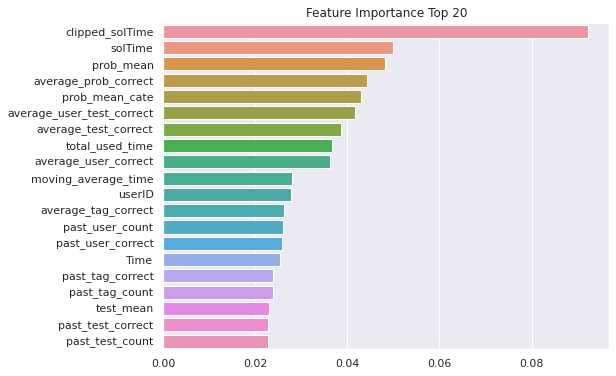

In [92]:
forest = RandomForestClassifier(n_estimators=5, n_jobs=-1, random_state=42) # n_estimators: 사용할 tree수
forest.fit(X_train, y_train)

# 배열형태로 반환
ft_importance_values = forest.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
ft_series = pd.Series(ft_importance_values, index = X_train.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()

In [93]:
lgb_data = lgb.Dataset(X_train, y_train)
model = lgb.train(
                    {'objective': 'binary'}, 
                    lgb_data,
                    valid_sets=lgb_data,
                    verbose_eval=100,
                    num_boost_round=500,
                    early_stopping_rounds=100
                )

[LightGBM] [Info] Number of positive: 1483205, number of negative: 783381
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.215279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6977
[LightGBM] [Info] Number of data points in the train set: 2266586, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654378 -> initscore=0.638341
[LightGBM] [Info] Start training from score 0.638341
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.450429
[200]	training's binary_logloss: 0.446773
[300]	training's binary_logloss: 0.444598
[400]	training's binary_logloss: 0.442641
[500]	training's binary_logloss: 0.440881
Did not meet early stopping. Best iteration is:
[500]	training's binary_logloss: 0.440881


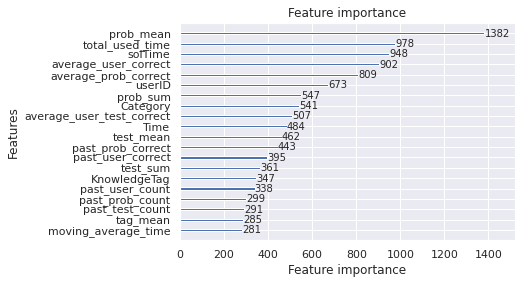

In [94]:
_ = lgb.plot_importance(model, max_num_features=20)

## Feature Importance (clipped_solTime_cate)

In [95]:
X_train2, y_train2 = df_new.loc[:,df_new.columns!='clipped_solTime_cate'], df_new['clipped_solTime_cate']

In [96]:
X_train2

,userID,answerCode,KnowledgeTag,Category,Time,solTime,item,item_order,test_size,retest,...,moving_average_user_correct,past_user_prob_count,past_user_prob_correct,average_user_prob_correct,past_user_test_count,past_user_test_correct,average_user_test_correct,past_user_tag_count,past_user_tag_correct,average_user_tag_correct
0,0,1,7224,6,1585009031,3,0,0,6,0,...,0.6,0,0.0,0.0,0,0.0,0.00,0,0.0,0.00
1,0,1,7225,6,1585009034,8,1,1,6,0,...,0.6,0,0.0,0.0,1,1.0,1.00,0,0.0,0.00
2,0,1,7225,6,1585009042,7,2,2,6,0,...,0.9,0,0.0,0.0,2,2.0,1.00,1,1.0,1.00
3,0,1,7225,6,1585009049,7,3,3,6,0,...,0.9,0,0.0,0.0,3,3.0,1.00,2,2.0,1.00
4,0,1,7225,6,1585009056,11,4,4,6,0,...,1.0,0,0.0,0.0,4,4.0,1.00,3,3.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,0,438,3,1591339821,0,4,4,5,0,...,0.7,0,0.0,0.0,4,1.0,0.25,4,1.0,0.25
2266582,7441,1,8836,4,1597971999,11,0,0,4,0,...,0.5,0,0.0,0.0,0,0.0,0.00,0,0.0,0.00
2266583,7441,1,8836,4,1597972010,46,1,1,4,0,...,0.5,0,0.0,0.0,1,1.0,1.00,1,1.0,1.00
2266584,7441,1,8836,4,1597972056,73,2,2,4,0,...,0.6,0,0.0,0.0,2,2.0,1.00,2,2.0,1.00


In [97]:
y_train2

0          0
1          0
2          0
3          0
4          1
          ..
2266581    0
2266582    1
2266583    4
2266584    7
2266585    0
Name: clipped_solTime_cate, Length: 2266586, dtype: int64

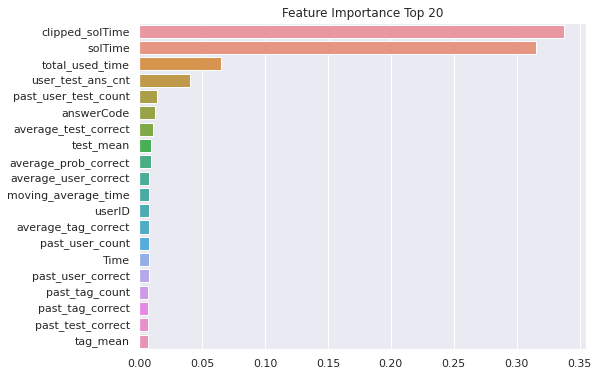

In [98]:
forest = RandomForestClassifier(n_estimators=5, n_jobs=-1, random_state=42) # n_estimators: 사용할 tree수
forest.fit(X_train2, y_train2)

# 배열형태로 반환
ft_importance_values = forest.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
ft_series = pd.Series(ft_importance_values, index = X_train2.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()